<a href="https://colab.research.google.com/github/GirijaKondapally/Girija_INFO5731_-Fall2023/blob/main/Copy_of_INFO5731_Assignment_Three_fall2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **INFO5731 Assignment Three**

In this assignment, you are required to conduct information extraction, semantic analysis based on **the dataset you collected from assignment two**. You may use scipy and numpy package in this assignment.

# **Question 1: Understand N-gram**

(45 points). Write a python program to conduct N-gram analysis based on the dataset in your assignment two:

(1) Count the frequency of all the N-grams (N=3).

(2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the **noun phrases** and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).


In [ ]:
# Write your code here

import requests
from bs4 import BeautifulSoup
from nltk import ngrams, word_tokenize, pos_tag, download
from collections import Counter
import pandas as pd

# Download NLTK
download('punkt')
download('averaged_perceptron_tagger')

def fetch_reviews(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    review = []
    review_elements = soup.find_all('div', class_='text show-more__control')
    for review_element in review_elements:
        review_text = review_element.get_text(strip=True)
        review.append(review_text)

    return review

def extract_ngrams(text, n):
    token = word_tokenize(text)
    n_gram = ngrams(token, n)
    return [' '.join(gram) for gram in n_gram]

def calculate_ngram_frequencies(dataset, n):
    ngram_frequencies = Counter()

    for review in dataset:
        ngrams_list = extract_ngrams(review, n)
        ngram_frequencies.update(ngrams_list)

    return ngram_frequencies

def calculate_bigram_probabilities(dataset):
    bigram_counts = Counter()
    unigram_counts = Counter()

    for review in dataset:
        tokens = word_tokenize(review)
        bigrams = list(ngrams(tokens, 2))
        unigrams = list(ngrams(tokens, 1))

        bigram_counts.update(bigrams)
        unigram_counts.update(unigrams)

    bigram_probabilities = {}
    for bigram, count in bigram_counts.items():
        unigram = bigram[0]

        if unigram_counts[unigram] != 0:
            probability = count / unigram_counts[unigram]
        else:
            probability = 0

        bigram_probabilities[bigram] = probability

    return bigram_probabilities

def calculate_relative_probabilities(dataset):
    noun_phrase_frequencies = Counter()

    for review in dataset:
        tokens = word_tokenize(review)
        tagged_tokens = pos_tag(tokens)

        # Extracting noun phrases
        noun_phrases = [word for word, pos in tagged_tokens if pos.startswith('NN')]

        noun_phrase_frequencies.update(noun_phrases)

    max_frequencies = noun_phrase_frequencies.most_common(1)[0][1]

    relative_probabilities = {}
    for review in dataset:
        tokens = word_tokenize(review)
        tagged_tokens = pos_tag(tokens)

        # Extracting noun phrases
        noun_phrases = [word for word, pos in tagged_tokens if pos.startswith('NN')]

        # Calculating relative probabilities
        relative_probabilities[review] = {noun: freq / max_frequencies for noun, freq in noun_phrase_frequencies.items()}

    return relative_probabilities

def display_results(ngram_frequencies, bigram_probabilities, relative_probabilities):
    print("N-gram Frequencies:")
    print(ngram_frequencies)

    print("\nBigram Probabilities:")
    print(bigram_probabilities)

    print("\nRelative Probabilities of Noun Phrases:")
    df = pd.DataFrame.from_dict(relative_probabilities, orient='index')
    print(df)

if __name__ == "__main__":
    url = "https://www.imdb.com/title/tt8178634/reviews?ref_=tt_urv"
    reviews = fetch_reviews(url)

    n = 3
    ngram_frequencies = calculate_ngram_frequencies(reviews, n)
    bigram_probabilities = calculate_bigram_probabilities(reviews)
    relative_probabilities = calculate_relative_probabilities(reviews)

    display_results(ngram_frequencies, bigram_probabilities, relative_probabilities)



Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.0 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [49.8 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,278 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubu

# **Question 2: Undersand TF-IDF and Document representation**

(20 points). Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the **documents-terms weights (tf*idf) matrix bold text**.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using **cosine similarity**.

In [ ]:
# Write your code here
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

url = "https://www.imdb.com/title/tt8178634/reviews?ref_=tt_urv"

def scrape_imdb_reviews(url, max_reviews=10000):
    review = []
    page = 1

    while len(review) < max_reviews:
        response = requests.get(url, params={"start": (page - 1) * 25})
        if response.status_code != 200:
            print(f"Failed to retrieve page {page}. Check your internet connection or the URL.")
            break

        soup = BeautifulSoup(response.content, "html.parser")
        review_elements = soup.find_all("div", class_="text")

        if not review_elements:
            print("No more reviews found.")
            break

        for review_element in review_elements:
            review_text = review_element.get_text(strip=True)
            reviews.append(review_text)

            if len(review) >= max_reviews:
                break

        page += 1

    return review

# Fetching reviews
review = scrape_imdb_reviews(url)

# writing a query
query = "An Outstanding movie with a haunting performance and best character development"

all_texts = review + [query]

# TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# cosine similarity
cosine_similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1]).flatten()

# Rank the documents
document_ranking = sorted(enumerate(cosine_similarities), key=lambda x: x[1], reverse=True)

# Display results
print("Query: ", query)
print("\nRanking of Documents:")
for rank, (doc_index, similarity) in enumerate(document_ranking, start=1):
    print(f"Rank {rank}: Document {doc_index + 1} - Similarity: {similarity:.4f}")








Streaming output truncated to the last 5000 lines.
Rank 5001: Document 5021 - Similarity: 0.0371
Rank 5002: Document 5046 - Similarity: 0.0371
Rank 5003: Document 5071 - Similarity: 0.0371
Rank 5004: Document 5096 - Similarity: 0.0371
Rank 5005: Document 5121 - Similarity: 0.0371
Rank 5006: Document 5146 - Similarity: 0.0371
Rank 5007: Document 5171 - Similarity: 0.0371
Rank 5008: Document 5196 - Similarity: 0.0371
Rank 5009: Document 5221 - Similarity: 0.0371
Rank 5010: Document 5246 - Similarity: 0.0371
Rank 5011: Document 5271 - Similarity: 0.0371
Rank 5012: Document 5296 - Similarity: 0.0371
Rank 5013: Document 5321 - Similarity: 0.0371
Rank 5014: Document 5346 - Similarity: 0.0371
Rank 5015: Document 5371 - Similarity: 0.0371
Rank 5016: Document 5396 - Similarity: 0.0371
Rank 5017: Document 5421 - Similarity: 0.0371
Rank 5018: Document 5446 - Similarity: 0.0371
Rank 5019: Document 5471 - Similarity: 0.0371
Rank 5020: Document 5496 - Similarity: 0.0371
Rank 5021: Document 5521 - Si

# **Question 3: Create your own word embedding model**

(20 points). Use the data you collected for assignment two to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit, bert, or others).

(2) Visualize the word embedding model you created.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

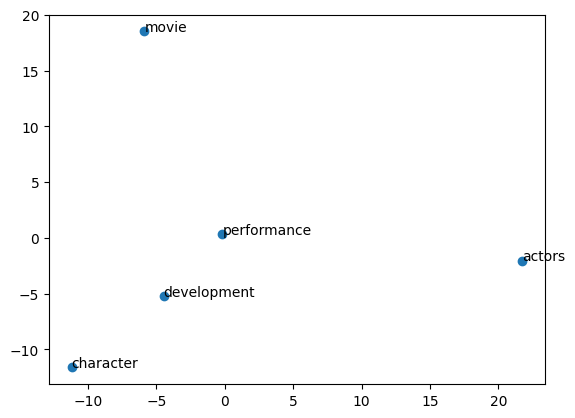

In [ ]:
# Write your code here


from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import requests
from bs4 import BeautifulSoup

url = "https://www.imdb.com/title/tt8178634/reviews?ref_=tt_urv"

def scrape_imdb_reviews(url, max_reviews=10000):
    review = []
    page = 1

    while len(review) < max_reviews:
        response = requests.get(url, params={"start": (page - 1) * 25})
        if response.status_code != 200:
            print(f"Failed to retrieve page {page}. Check your internet connection or the URL.")
            break

        soup = BeautifulSoup(response.content, "html.parser")
        review_elements = soup.find_all("div", class_="text")

        if not review_elements:
            print("No more reviews found.")
            break

        for review_element in review_elements:
            review_text = review_element.get_text(strip=True)
            reviews.append(review_text)

            if len(review) >= max_reviews:
                break

        page += 1

    return review

# Fetch reviews
review = scrape_imdb_reviews(url)

# tokenization and cleaning
def preprocess_text(text):
    # splitting into words
    word = re.findall(r'\b\w+\b', text.lower())
    return word

tokenized_reviews = [preprocess_text(review) for reviews in review]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_reviews, vector_size=300, window=5, min_count=1, workers=4)
model.save("word2vec_model_imdb.bin")

# Visualize Word Embeddings using PCA
def plot_word_embeddings(model, word):
    X = model.wv[word]
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)

    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    plt.show()

# Visualize a subset of words (replace with words from your dataset)
words_to_visualize = ["movie", "character", "performance", "development", "actors"]
plot_word_embeddings(model, words_to_visualize)





# **Question 4: Create your own training and evaluation data for sentiment analysis**

(15 points). **You dodn't need to write program for this question!** Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral). Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew. This datset will be used for assignment four: sentiment analysis and text classification.


In [ ]:
# The GitHub link of your final csv file

# Link:


https://github.com/GirijaKondapally/Girija_INFO5731_-Fall2023/blob/main/imdb_review_sentiment_analysis.csv

